In order to do an analysis of sentiment data on stock prices, we narrowed down our focus to environmental stocks. We first connected two data sets: sentiment data from tweets that had to with the environment data and intraday stock open price data on one ticker(Exxon Mobil) that we thought would be affected by sentiment. 

Then we created features from the sentiment data by aggregating by data strongly pointed tweets by those categorized as climate change believers and deniers(in both directions >0.5) to create four features. We then created a lagged price column to shift our time series data into a format that we could easily formulate as a regression problem using Catboost. We expect lagged price by far to be the most important column but we saw that there was explanatory power added by our sentiment columns. Generally negative tweets by climate change believers were most impactful out of the four but in our SHAP plots, we also saw that high values of negative tweets by climate change deniers also had an effect.

There are many ways to take this analysis if we were in a setting where we wanted to productionize this sort of analysis. There are obvious minor things to fix such as accounting for dividends and stock splits and evaluating a large universe of stocks(Oil, ESG etc). It would also be important to add other signals/factors such that we can see if this sentiment data adds predictiveness beyond a normal value/momentum based model for instance. It would also be good to factor in general returns of the market so we measure whether this signal is tracking the alpha. We would ideally have a backtesting mechanism where we can test different thresholds&trading rules to see if a trading system based on this signal would historically create a good Sharpe ratio(returns/volatility). In the interest of time we also used a publically available twitter data set, if we are scraping our own or using a vendor with more data, we could also try to identify which Twitter accounts move the needle more and use other information such as the geo or do a graph network analysis to see if the way in which certain information disseminates could be engineered as a feature.

In [1]:
# https://www.kaggle.com/datasets/deffro/the-climate-change-twitter-dataset
# tweets pertaining to climate change 2006-2019

In [64]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

In [5]:
sentiment = pd.read_csv("twitter_data.csv")

In [7]:
sentiment.dtypes

created_at          object
id                   int64
lng                float64
lat                float64
topic               object
sentiment          float64
stance              object
gender              object
temperature_avg    float64
aggressiveness      object
dtype: object

In [32]:
sentiment.groupby('date')

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness,date
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive,2006-06-06
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive,2006-07-23
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive,2006-08-29
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive,2006-11-07
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive,2006-11-27
...,...,...,...,...,...,...,...,...,...,...,...
15789406,2019-10-01 05:50:32+00:00,1178910045783937024,NaN,NaN,Global stance,-0.010875,believer,male,NaN,not aggressive,2019-10-01
15789407,2019-10-01 05:50:49+00:00,1178910117095305216,-118.243680,34.052230,Global stance,-0.685905,believer,female,-3.126811,not aggressive,2019-10-01
15789408,2019-10-01 05:53:37+00:00,1178910821750992896,100.501440,13.753980,Politics,0.343705,neutral,female,-0.364467,not aggressive,2019-10-01
15789409,2019-10-01 05:54:37+00:00,1178911073371643904,NaN,NaN,Politics,-0.088496,believer,female,NaN,not aggressive,2019-10-01


In [29]:
sentiment['date'] = pd.to_datetime(sentiment['created_at'])
sentiment['date'] = sentiment['date'].dt.date

In [45]:
believer_positive = sentiment[sentiment['stance'] == 'believer'].groupby('date').apply(lambda x: (x['sentiment'] > 0.5).sum()).reset_index(name='count')
believer_negative = sentiment[sentiment['stance'] == 'believer'].groupby('date').apply(lambda x: (x['sentiment'] < -0.5).sum()).reset_index(name='count')
denier_positive = sentiment[sentiment['stance'] == 'denier'].groupby('date').apply(lambda x: (x['sentiment'] > 0.5).sum()).reset_index(name='count')
denier_negative = sentiment[sentiment['stance'] == 'denier'].groupby('date').apply(lambda x: (x['sentiment'] < -0.5).sum()).reset_index(name='count')

/var/folders/g7/bpp4cx6s1g39r2zq03cdwt_40000gp/T/ipykernel_8434/867516121.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  believer_positive = sentiment[sentiment['stance'] == 'believer'].groupby('date').apply(lambda x: (x['sentiment'] > 0.5).sum()).reset_index(name='count')
/var/folders/g7/bpp4cx6s1g39r2zq03cdwt_40000gp/T/ipykernel_8434/867516121.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  belie

In [49]:
believer_positive = believer_positive.rename(columns = {"count": "believer_positive"})
believer_negative = believer_negative.rename(columns = {"count": "believer_negative"})
denier_positive = denier_positive.rename(columns = {"count": "denier_positive"})
denier_negative = denier_negative.rename(columns = {"count": "denier_negative"})

In [52]:
df = pd.merge(believer_positive, believer_negative, how = 'outer', on = 'date')
df = pd.merge(df, denier_positive, how = 'outer', on = 'date')
df = pd.merge(df, denier_negative, how = 'outer', on = 'date')
df['total'] = df['believer_positive']+df['believer_negative']+df['denier_positive']+df['denier_negative']
df

,date,believer_positive,believer_negative,denier_positive,denier_negative,total
0,2006-12-11,0.0,0.0,NaN,NaN,NaN
1,2006-12-17,NaN,NaN,0.0,1.0,NaN
2,2006-12-29,1.0,0.0,NaN,NaN,NaN
3,2007-01-11,0.0,0.0,NaN,NaN,NaN
4,2007-01-16,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
4015,2019-09-27,140.0,97.0,15.0,23.0,275.0
4016,2019-09-28,122.0,75.0,11.0,30.0,238.0
4017,2019-09-29,73.0,39.0,3.0,25.0,140.0
4018,2019-09-30,69.0,345.0,5.0,18.0,437.0


In [53]:
from matplotlib import pyplot as plt

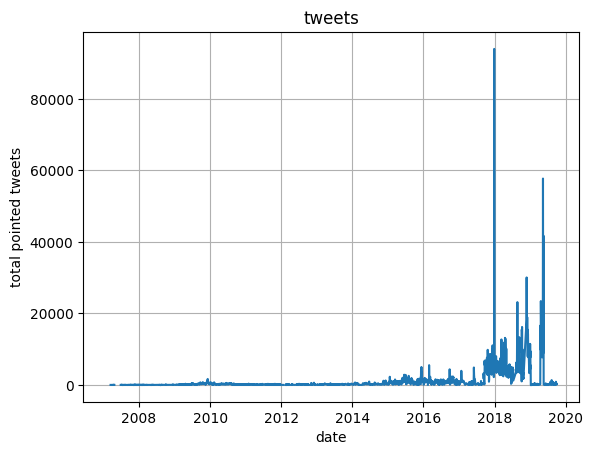

In [54]:
fig, ax = plt.subplots()
ax.plot(df['date'], df['total'])

ax.set(xlabel='date', ylabel='total pointed tweets',
       title='tweets')
ax.grid()

fig.savefig("test.png")
plt.show()

In [69]:
df = df[df['date'] > dt.datetime.strptime("01-01-2019", '%m-%d-%Y').date()]

In [70]:
df

,date,believer_positive,believer_negative,denier_positive,denier_negative,total
3754,2019-01-02,4351.0,6111.0,262.0,747.0,11471.0
3755,2019-01-03,3907.0,3032.0,103.0,550.0,7592.0
3756,2019-01-04,3335.0,5565.0,80.0,509.0,9489.0
3757,2019-01-05,2206.0,2220.0,69.0,363.0,4858.0
3758,2019-01-06,2394.0,1772.0,56.0,341.0,4563.0
...,...,...,...,...,...,...
4015,2019-09-27,140.0,97.0,15.0,23.0,275.0
4016,2019-09-28,122.0,75.0,11.0,30.0,238.0
4017,2019-09-29,73.0,39.0,3.0,25.0,140.0
4018,2019-09-30,69.0,345.0,5.0,18.0,437.0


In [16]:
import yfinance as yf

In [90]:
def download_intraday(ticker):
    dat= yf.Ticker(ticker)
    intraday = dat.history(start="2019-01-01", end="2019-10-01", interval="1d")
    intraday = intraday.reset_index()
    intraday['date'] = pd.to_datetime(intraday['Date'])
    intraday['date'] = intraday['date'].dt.date
    intraday = intraday[['date', 'Open']] #should incorporate stock splits
    intraday = intraday.rename(columns = {"Open": "price"})
    return intraday

In [143]:
price = download_intraday("XOM") #EXXON Mobil
data = pd.merge(price, df, how = 'left', on = 'date')

In [144]:
data['lagged_price'] = data['price'].shift(1)
data

,date,price,believer_positive,believer_negative,denier_positive,denier_negative,total,lagged_price
0,2019-01-02,51.670378,4351.0,6111.0,262.0,747.0,11471.0,NaN
1,2019-01-03,53.703441,3907.0,3032.0,103.0,550.0,7592.0,51.670378
2,2019-01-04,53.427258,3335.0,5565.0,80.0,509.0,9489.0,53.703441
3,2019-01-07,54.662440,3166.0,1855.0,47.0,414.0,5482.0,53.427258
4,2019-01-08,55.652116,171.0,184.0,2.0,112.0,469.0,54.662440
...,...,...,...,...,...,...,...,...
183,2019-09-24,57.042738,359.0,289.0,27.0,214.0,889.0,56.812389
184,2019-09-25,56.383445,120.0,226.0,31.0,63.0,440.0,57.042738
185,2019-09-26,56.574085,89.0,113.0,8.0,25.0,235.0,56.383445
186,2019-09-27,56.161010,140.0,97.0,15.0,23.0,275.0,56.574085


In [134]:
from catboost import CatBoostRegressor, Pool

In [108]:
from sklearn.model_selection import train_test_split 

In [145]:
X, y = data[['lagged_price', 'believer_positive', 'believer_negative', 'denier_positive', 'denier_negative']], data['price']

In [146]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 

In [147]:
model = CatBoostRegressor(iterations=200,
                          learning_rate=0.4,
                          depth=16)

In [148]:
model.fit(train_X, train_y)

0:	learn: 2.3611763	total: 20.7ms	remaining: 4.12s
1:	learn: 1.8374759	total: 24.4ms	remaining: 2.42s
2:	learn: 1.5390858	total: 72.5ms	remaining: 4.76s
3:	learn: 1.2157340	total: 80.2ms	remaining: 3.93s
4:	learn: 1.0047975	total: 114ms	remaining: 4.45s
5:	learn: 0.8975484	total: 194ms	remaining: 6.28s
6:	learn: 0.7616890	total: 196ms	remaining: 5.39s
7:	learn: 0.6804213	total: 277ms	remaining: 6.66s
8:	learn: 0.5903484	total: 292ms	remaining: 6.19s
9:	learn: 0.5378293	total: 295ms	remaining: 5.61s
10:	learn: 0.4830134	total: 296ms	remaining: 5.08s
11:	learn: 0.4380469	total: 373ms	remaining: 5.84s
12:	learn: 0.3999524	total: 453ms	remaining: 6.52s
13:	learn: 0.3668875	total: 532ms	remaining: 7.06s
14:	learn: 0.3351507	total: 612ms	remaining: 7.55s
15:	learn: 0.3068195	total: 691ms	remaining: 7.94s
16:	learn: 0.2761877	total: 772ms	remaining: 8.31s
17:	learn: 0.2508305	total: 853ms	remaining: 8.62s
18:	learn: 0.2303506	total: 932ms	remaining: 8.88s
19:	learn: 0.2260113	total: 933ms	rem

In [149]:
shap.initjs()

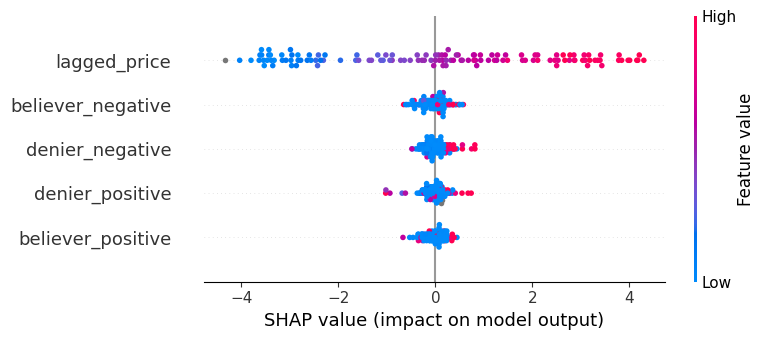

In [150]:
import shap
shap_values = model.get_feature_importance(Pool(train_X, train_y), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.summary_plot(shap_values, train_X)

Text(0.5, 1.0, 'Feature Importance')

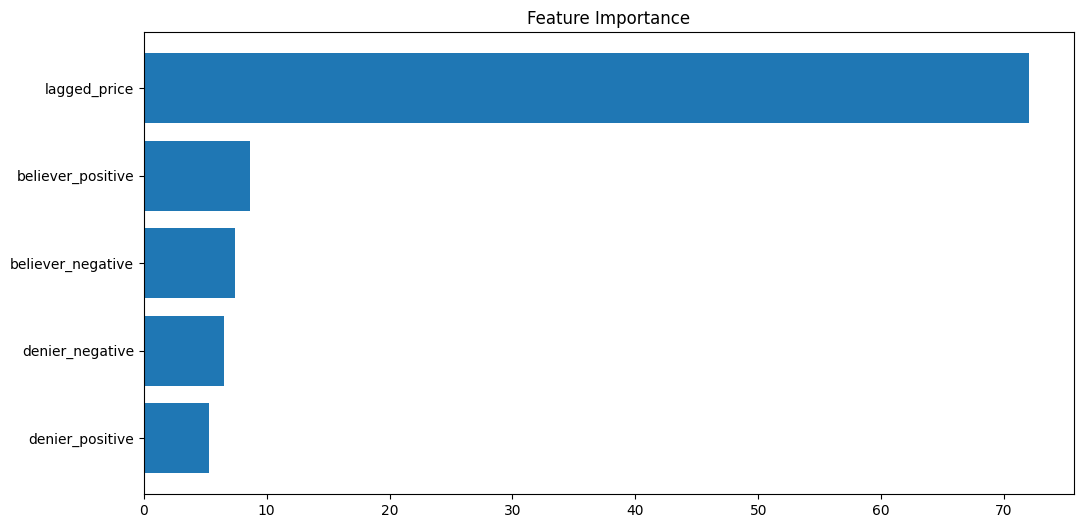

In [154]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('Feature Importance')